#Questions: do we have to identiy misformat in dataset that does not relato to our solution

# 1. Business Understanding

a)

- Business Problem: Optimize vehicle design to help defining sales and marketing strategies by identifying which features most influence consumer demand.
- Consider insights: The dataset including different car model and its components, which can be analyzed to predict trend, optimize price and identify which component of an automobile shoud be prioritized.

b)

Three potential data solutions:
- Train a regression to predict Popularity, then extract feature importance
  - Feasibility: high, we already have data with clear feature and target variable (Popularity)
- Train a regression mix of engine fuel type, engine HP, engine cylinders, and driven-wheels gives the best overall fuel economy (city and highway MPG)
  - Feasibility: high, already have data with clear feature and target variable (city and highway MPG)
- Using EDA and correlation analysis to identiy trend between market price and automobile
  - Feasibility: high, the dataset already includes MSRP (target) and relevant features (Engine HP, Market Category, Vehicle Size, etc.).

After careful consideration, I decided to go with second option because regression in second solution has fewer key variables, which lead to more stable prediction. The second option also tackle a specific business selling point, which for those automobile brands who want to prioritize MPG.

c) 
Hierachal domain graph

![Hierachal domain graph](Screenshot%202025-05-23%20at%203.39.54 AM.png)

d)

| **Feature Name**   | **Domain Concept**  | **Feature Description**                                                             | **Feature Type** | **Data Type**     |
|--------------------|--------------------|-------------------------------------------------------------------------------------|------------------|-------------------|
| `city_mpg`         | Fuel Economy       | Fuel efficiency in city driving conditions                                          | Target           | Numeric      |
| `highway_mpg`      | Fuel Economy       | Fuel efficiency in highway driving conditions                                       | Target           | Numeric      |
| `combined_mpg` | Fuel Economy       | Ratio of fuel efficiency while driving in city and highway, with ratio 55% city and 45% highway | Derived          | Numeric    |
| `engine_hp`        | Engine             | Engine horsepower                                                                   | Predictor        | Numeric      |
| `engine_cylinders` | Engine             | Number of cylinders                                                                 | Predictor        | Numeric     |
| `engine_fuel_type` | Engine             | Type of fuel engine uses                                                            | Predictor        | Categorical       |
| `driven_wheels`    | Drivetrain Layout  | Wheels of the vehicle receiving power from the engine to propel the vehicle         | Predictor        | Categorical       |



# 2. Data Exploration

In [37]:
import pandas as pd

df = pd.read_csv('data.csv')
print(df.columns)


Index(['Make', 'Model', 'Year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'Transmission Type', 'driven_wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway_mpg', 'city_mpg', 'Popularity', 'MSRP'],
      dtype='object')


In [38]:
# Standardize column names
df.columns = (
    df.columns
    .str.strip()                   
    .str.lower()                    
    .str.replace(' ', '_')          
    .str.replace('[^0-9a-zA-Z_]', '', regex=True) 
)
print(df.columns)

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')


In [39]:
# Completeness
num_rows = len(df)

subset_cols = ['city_mpg', 'highway_mpg', 'engine_fuel_type', 
               'engine_hp', 'engine_cylinders', 'driven_wheels']
num_rows_with_missing_values = df[subset_cols].isnull().any(axis=1).sum()

num_missing_city_mpg = df['city_mpg'].isnull().sum()
num_missing_highway_mpg = df['highway_mpg'].isnull().sum()
num_missing_fuel_type = df['engine_fuel_type'].isnull().sum()
num_missing_engine_hp = df['engine_hp'].isnull().sum()
num_missing_engine_cylinders = df['engine_cylinders'].isnull().sum()
num_missing_drive_type = df['driven_wheels'].isnull().sum()

print(f"Number of rows with missing values: {num_rows_with_missing_values} ({num_rows_with_missing_values / num_rows * 100:.2f}%)")

print(f"Number of missing city_mpg values: {num_missing_city_mpg} ({num_missing_city_mpg / num_rows * 100:.2f}%)")
print(f"Number of missing highway_mpg values: {num_missing_highway_mpg} ({num_missing_highway_mpg / num_rows * 100:.2f}%)")
print(f"Number of missing engine_fuel_type values: {num_missing_fuel_type} ({num_missing_fuel_type / num_rows * 100:.2f}%)")
print(f"Number of missing engine_hp values: {num_missing_engine_hp} ({num_missing_engine_hp / num_rows * 100:.2f}%)")
print(f"Number of missing engine_cylinders values: {num_missing_engine_cylinders} ({num_missing_engine_cylinders / num_rows * 100:.2f}%)")
print(f"Number of missing driven_wheels values: {num_missing_drive_type} ({num_missing_drive_type / num_rows * 100:.2f}%)")



Number of rows with missing values: 101 (0.85%)
Number of missing city_mpg values: 0 (0.00%)
Number of missing highway_mpg values: 0 (0.00%)
Number of missing engine_fuel_type values: 3 (0.03%)
Number of missing engine_hp values: 69 (0.58%)
Number of missing engine_cylinders values: 30 (0.25%)
Number of missing driven_wheels values: 0 (0.00%)


In [40]:
# Uniqueness
print(f"Duplicate rows: {df.duplicated().sum()} ({df.duplicated().sum() / num_rows * 100:.2f}%)")

Duplicate rows: 715 (6.00%)


In [41]:
# Consistency
print(df.dtypes)

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object


In [42]:
# engine_cylinders needs to be an integer and non-negative
negative_cylinders = (df['engine_cylinders'] < 0).sum()
non_integer_cylinders = ((df['engine_cylinders'] % 1 != 0) & df['engine_cylinders'].notna()).sum()
print(f"Negative engine_cylinders: {negative_cylinders} rows")
print(f"Non-integer engine_cylinders: {non_integer_cylinders} rows")


Negative engine_cylinders: 0 rows
Non-integer engine_cylinders: 0 rows


In [43]:
# engine_hp, city_mpg, and highway_mpg should be non-negative
misformat_engine_hp = (df['engine_hp'] < 0).sum()
misformat_city_mpg = (df['city_mpg'] < 0).sum()
misformat_highway_mpg = (df['highway_mpg'] < 0).sum()
print(f"Negative engine_hp: {misformat_engine_hp} rows")
print(f"Negative city_mpg: {misformat_city_mpg} rows")
print(f"Negative highway_mpg: {misformat_highway_mpg} rows")

Negative engine_hp: 0 rows
Negative city_mpg: 0 rows
Negative highway_mpg: 0 rows


In [44]:
# Validating categorical variables
print(f"Unique Engine Fuel values: {df['engine_fuel_type'].unique()}")
print(f"Unique Driven Wheels values: {df['driven_wheels'].unique()}")

Unique Engine Fuel values: ['premium unleaded (required)' 'regular unleaded'
 'premium unleaded (recommended)' 'flex-fuel (unleaded/E85)' 'diesel'
 'electric' 'flex-fuel (premium unleaded recommended/E85)' 'natural gas'
 'flex-fuel (premium unleaded required/E85)'
 'flex-fuel (unleaded/natural gas)' nan]
Unique Driven Wheels values: ['rear wheel drive' 'front wheel drive' 'all wheel drive'
 'four wheel drive']


In [45]:
# check if electric car has cylinders
electric_cylinders = ((df['engine_fuel_type'] == 'electric') & (df['engine_cylinders'] > 0)).sum()
print(f"Electric cars with cylinders: {electric_cylinders} rows")

Electric cars with cylinders: 0 rows


### Result findings:
General findings:
- Duplicated rows: 715 (6%)
- Rows with at least 1 missing values: 101 (0.85%)
- Missing data in engine_fuel_type, engine_hp, and engine_cylinders columns
- Column names need to be standadized for better manipulation

| Feature             | Current Type | Missing Values | Misformatted Values      | Rules Checked                                                                 | Notes                                                                 |
|---------------------|--------------|----------------|--------------------------|------------------------------------------------------------------------------|-----------------------------------------------------------------------|
| `city_mpg`          | int64        | 0 (0.00%)      | 0                        | No missing values, no negative values                                        | Data looks clean                                                      |
| `highway_mpg`       | int64        | 0 (0.00%)      | 0                        | No missing values, no negative values                                        | Data looks clean                                                      |
| `engine_fuel_type`  | object       | 3 (0.03%)      | 0                        | Missing values, unique values inspected                                      | Includes flex-fuel and alternative types, plus missing (nan)          |
| `engine_hp`         | float64      | 69 (0.58%)     | 0                        | Missing values, checked for negative values                                  | No negative values found                                              |
| `engine_cylinders`  | float64      | 30 (0.25%)     | 0          | Missing values, checked for negative values and non-integer formatting       | Non-integer values may need rounding or type conversion               |
| `driven_wheels`     | object       | 0 (0.00%)      | 0                        | No missing values, unique values inspected                                   | Contains common types (FWD, RWD, AWD, 4WD)                            |


### Data Quality Plan
1. Standadize column names: convert all column names to lowercase snake_case for easier manipulation
2. Fix data types: 
- convert `engine_cylinders` to integer type 
3. Handle dyplicated rows: delete exact duplicated ones
4. Hanlde missing values
- Fill missing `engine_fuel_type` values with their online specifications (missing values is only 3)
- Fill missing `engine_hp`values with median value
- Fill missing `engine_cylinders` values with with most common cylinders number
5. Derive `combined_mpg` as weigted average: 
- combined_mpg = 0.55 * city_mpg + 0.45 * highwat MPG
- this captures overall fuel efficiency more comprehensively
6. For electric car with cylinders > 0, consider 2 cases:
- If it is due to human error, set the value to 0
- If the car is hybrid, consider changing the fuel type from `electric` to `hybrid`
7. Group and rename `engine_fuel_type` to reduce noise and improve interpretability:
- group `premium unleaded (required)` and `premium unleaded (recommended)` into `premium`
- group `flex-fuel (premium unleaded recommended/E85)` and `flex-fuel (premium unleaded required/E85` to `flex_premium`
- rename `flex-fuel (unleaded/natural gas)` to `flex_other`
- rename `flex-fuel (unleaded/E85)` to `flex_regular`
- rename `regular unleaded` to `regular`
8. Encode categorical variables for `engine_cylinders` and `driven_wheels`



# 3. Data Preparation

In [46]:
# Standadize column names is implemented above

In [47]:
# Convert engine_cylinders to integer
df['engine_cylinders'] = df['engine_cylinders'].astype('Int64', errors='ignore')


In [48]:
# Handle missing values for engine_cylinders
missing_fuel_type_rows = df.loc[df['engine_fuel_type'].isnull(), ['make', 'model', 'year']]
print(missing_fuel_type_rows)


         make   model  year
11321  Suzuki  Verona  2004
11322  Suzuki  Verona  2004
11323  Suzuki  Verona  2004


In [49]:
# From Suzuki website, the missing value is 'regular unleaded'
# Fill the missing value with 'regular unleaded'
df.fillna({'engine_fuel_type': 'regular unleaded'}, inplace=True)

# Check if the missing value is filled
print(f"Missing engine_fuel_type: {df['engine_fuel_type'].isnull().sum()} rows")

Missing engine_fuel_type: 0 rows


In [50]:
# Handle missing values for engine_hp
median_engine_hp = df['engine_hp'].median()
df.fillna({'engine_hp': median_engine_hp}, inplace=True)
# Check if the missing value is filled
print(f"Missing engine_hp: {df['engine_hp'].isnull().sum()} rows")

# Handle missing values for engine_cylinders
median_engine_cylinders = df['engine_cylinders'].median()
df.fillna({'engine_cylinders': median_engine_cylinders}, inplace=True)
# Check if the missing value is filled
print(f"Missing engine_cylinders: {df['engine_cylinders'].isnull().sum()} rows")

Missing engine_hp: 0 rows
Missing engine_cylinders: 0 rows


In [51]:
# Derive combined_mpg
df['combined_mpg'] = (0.55 * df['city_mpg'] + 0.45 * df['highway_mpg'])
print(f"Combined MPG: {df['combined_mpg'].head()}")

Combined MPG: 0    22.15
1    23.05
2    23.60
3    22.50
4    22.50
Name: combined_mpg, dtype: float64


In [52]:
# Check for rows with electric fuel type and non-zero cylinders
models_and_years = df.loc[
    (df['engine_fuel_type'] == 'electric') & (df['engine_cylinders'] > 0),
    ['make', 'model', 'year']
].drop_duplicates()

print(models_and_years)

            make    model  year
1983   Chevrolet  Bolt EV  2017
3716  Volkswagen   e-Golf  2015
3718  Volkswagen   e-Golf  2016
5778  Mitsubishi   i-MiEV  2014
5779  Mitsubishi   i-MiEV  2016
5780  Mitsubishi   i-MiEV  2017
8373      Toyota  RAV4 EV  2012


In [53]:
# For all of the car model, they are all fully electric, so we can set the engine_cylinders to 0
df.loc[
    (df['engine_fuel_type'] == 'electric') & (df['engine_cylinders'] > 0),
    'engine_cylinders'
] = 0
# Check if the engine_cylinders is set to 0 for electric cars
print(f"Electric cars with cylinders: {df.loc[(df['engine_fuel_type'] == 'electric') & (df['engine_cylinders'] > 0), 'engine_cylinders'].sum()} rows")

Electric cars with cylinders: 0 rows


In [54]:
# Group and rename engine fuel types
df['engine_fuel_type'] = df['engine_fuel_type'].replace({
    'premium unleaded (required)': 'premium',
    'premium unleaded (recommended)': 'premium',
    'flex-fuel (premium unleaded recommended/E85)': 'flex_premium',
    'flex-fuel (premium unleaded required/E85)': 'flex_premium',
    'flex-fuel (unleaded/natural gas)': 'flex_other',
    'flex-fuel (unleaded/E85)': 'flex_regular',
    'regular unleaded': 'regular'
})

# Check unique values after grouping
print(f"Unique Engine Fuel values after grouping: {df['engine_fuel_type'].unique()}")

Unique Engine Fuel values after grouping: ['premium' 'regular' 'flex_regular' 'diesel' 'electric' 'flex_premium'
 'natural gas' 'flex_other']


In [55]:
# Save the cleaned data
df.to_csv('cleaned_data.csv', index=False)

In [56]:
# Encode engine_fuel_type, and driven_wheels
df_encoded = pd.get_dummies(df, columns=['engine_fuel_type', 'driven_wheels'], drop_first=True)

# Check the transformed columns
print(df_encoded.columns)

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'number_of_doors', 'market_category',
       'vehicle_size', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'popularity', 'msrp', 'combined_mpg', 'engine_fuel_type_electric',
       'engine_fuel_type_flex_other', 'engine_fuel_type_flex_premium',
       'engine_fuel_type_flex_regular', 'engine_fuel_type_natural gas',
       'engine_fuel_type_premium', 'engine_fuel_type_regular',
       'driven_wheels_four wheel drive', 'driven_wheels_front wheel drive',
       'driven_wheels_rear wheel drive'],
      dtype='object')


In [57]:
# Save the cleaned encoded data for futher regression analysis
df_encoded.to_csv('cleaned_encoded_data.csv', index=False)

# 4. Data Insights

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cleaned = pd.read_csv('cleaned_data.csv')

related_columns = ['engine_hp', 'engine_cylinders', 'engine_fuel_type', 'driven_wheels', 'city_mpg', 'highway_mpg', 'combined_mpg']
related_continuous_columns = ['engine_hp', 'engine_cylinders', 'city_mpg', 'highway_mpg', 'combined_mpg']

In [75]:
# Print out summary statistics and skewness
print(df_cleaned[related_columns].describe())

          engine_hp  engine_cylinders      city_mpg   highway_mpg  \
count  11914.000000      11914.000000  11914.000000  11914.000000   
mean     249.256421          5.624727     19.733255     26.637485   
std      108.888444          1.785838      8.987798      8.863001   
min       55.000000          0.000000      7.000000     12.000000   
25%      170.000000          4.000000     16.000000     22.000000   
50%      227.000000          6.000000     18.000000     26.000000   
75%      300.000000          6.000000     22.000000     30.000000   
max     1001.000000         16.000000    137.000000    354.000000   

       combined_mpg  
count  11914.000000  
mean      22.840159  
std        8.678234  
min        9.250000  
25%       18.350000  
50%       21.600000  
75%       25.950000  
max      172.500000  


In [73]:
# Print out skewness
print(df_cleaned[related_continuous_columns].skew())

engine_hp           1.298034
engine_cylinders    0.934223
city_mpg            7.106681
highway_mpg         7.573931
combined_mpg        6.016090
dtype: float64


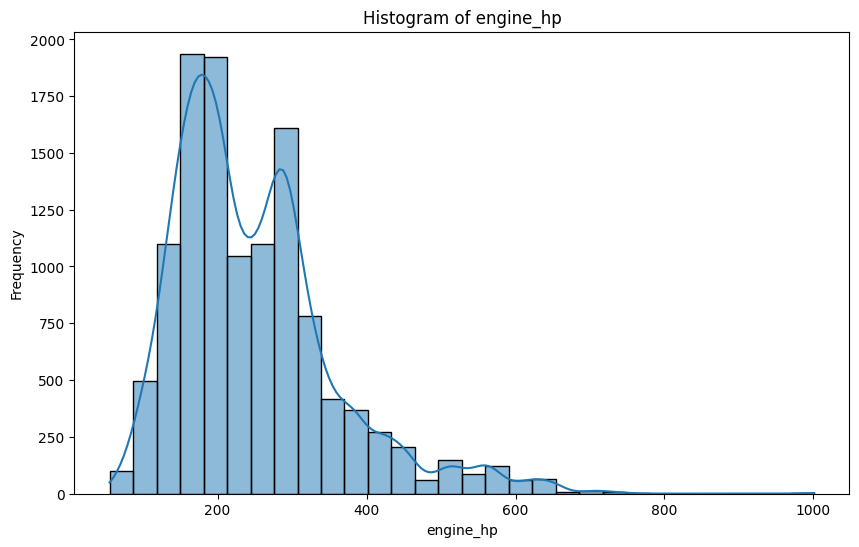

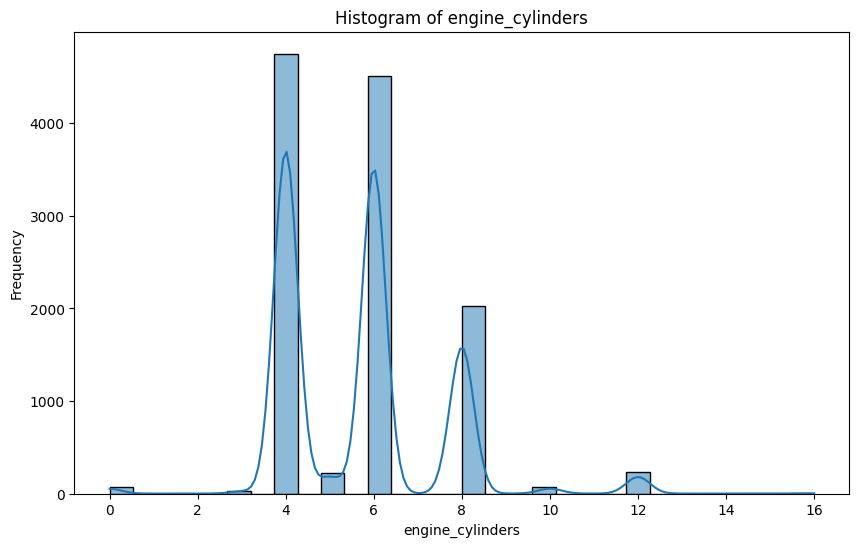

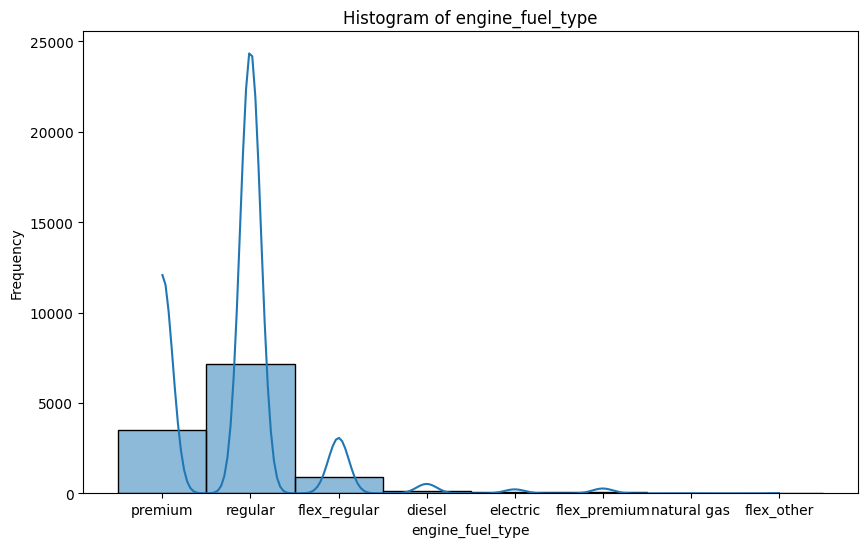

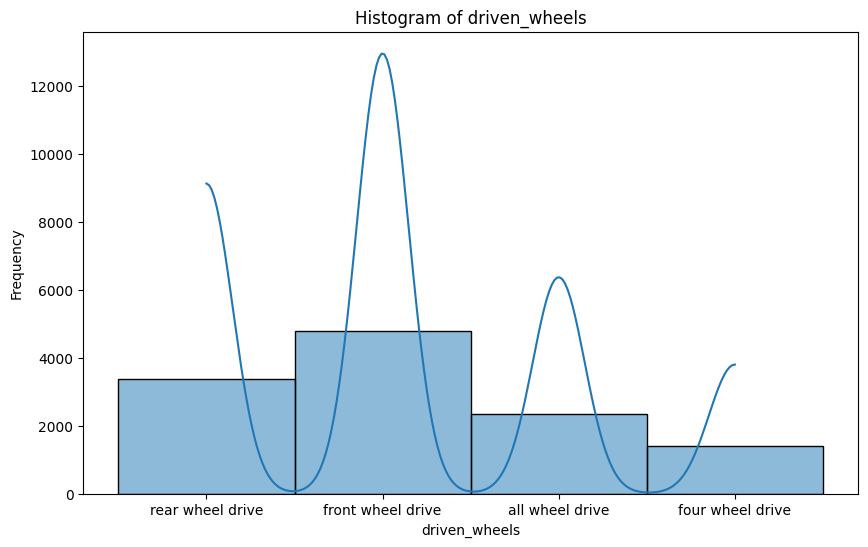

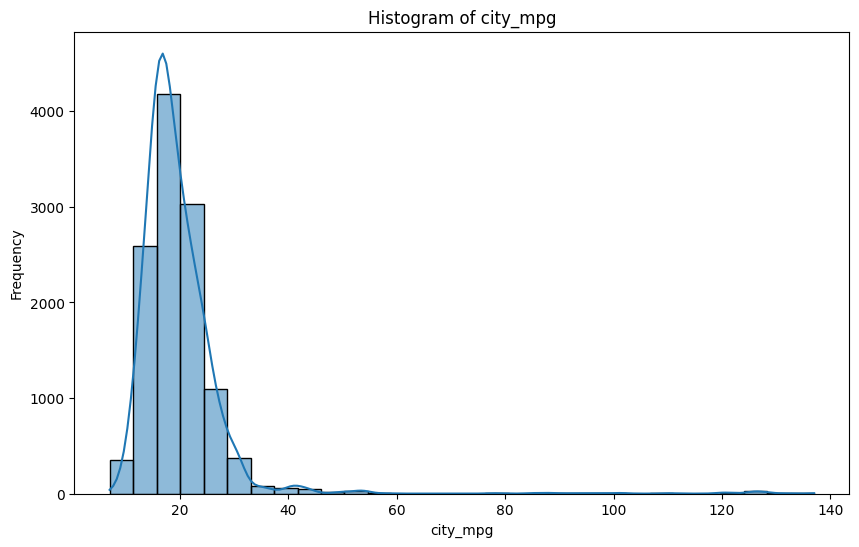

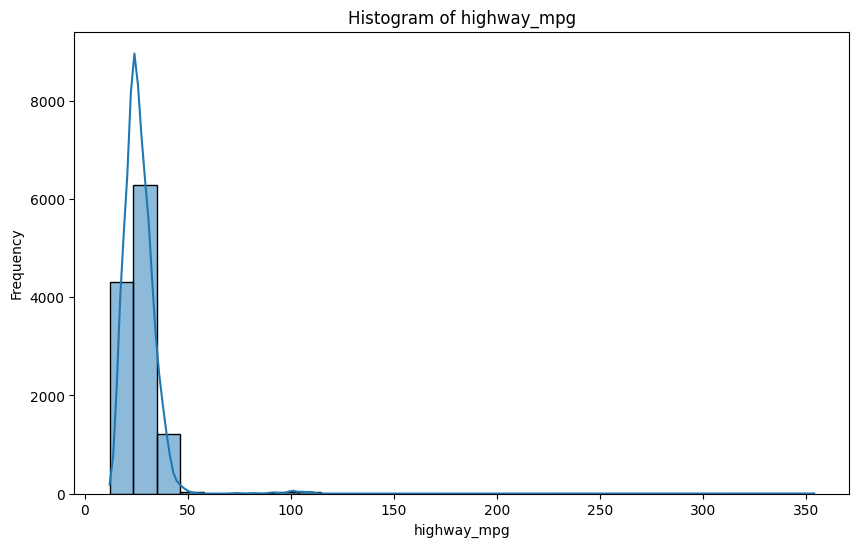

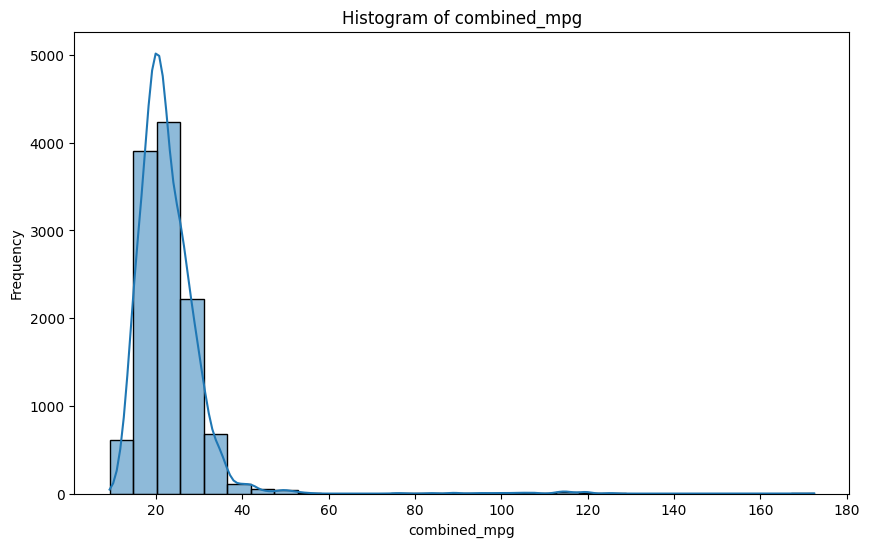

In [64]:
# Draw histograms for each column
for col in related_columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.histplot(df_cleaned[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

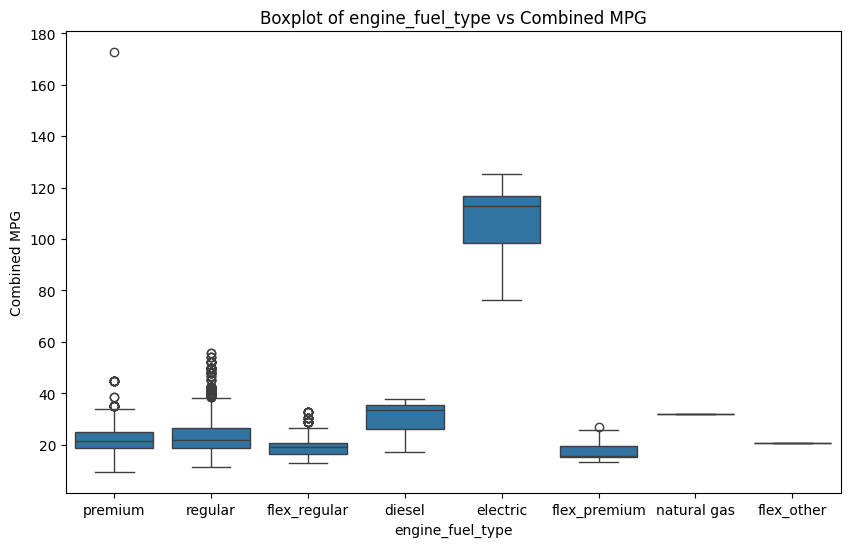

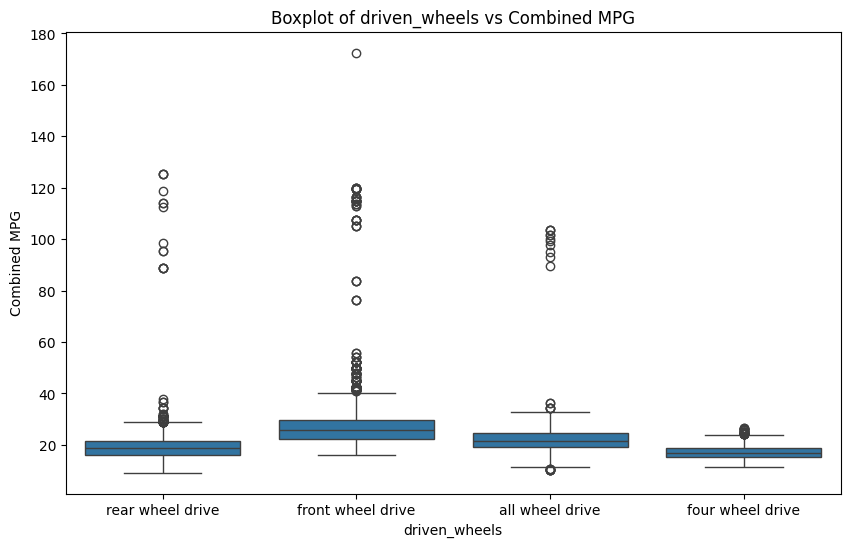

In [ ]:
# Correlation analysis

# Draw boxplots of fuel economy based on engine_fuel_type and driven_wheels
for col in ['engine_fuel_type', 'driven_wheels']:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.boxplot(x=col, y='combined_mpg', data=df_cleaned)
    plt.title(f'Boxplot of {col} vs Combined MPG')
    plt.xlabel(col)
    plt.ylabel('Combined MPG')
    plt.show()

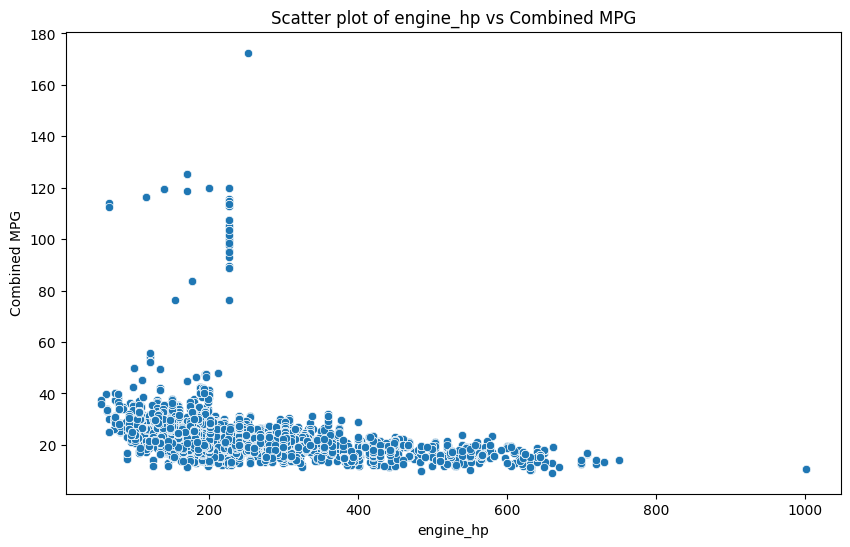

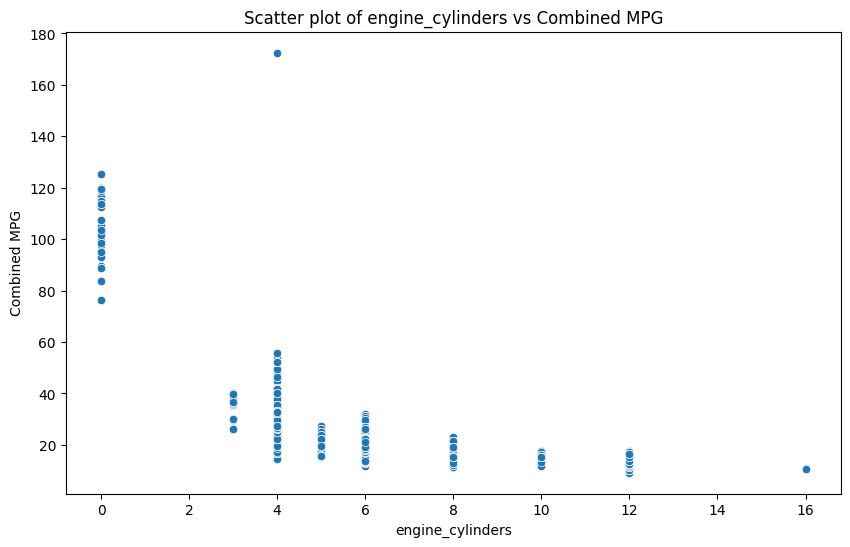

In [78]:
# Draw scatter plots of of fuel economy based on engine_hp and engine_cylinders
for col in ['engine_hp', 'engine_cylinders']:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.scatterplot(x=col, y='combined_mpg', data=df_cleaned)
    plt.title(f'Scatter plot of {col} vs Combined MPG')
    plt.xlabel(col)
    plt.ylabel('Combined MPG')
    plt.show()

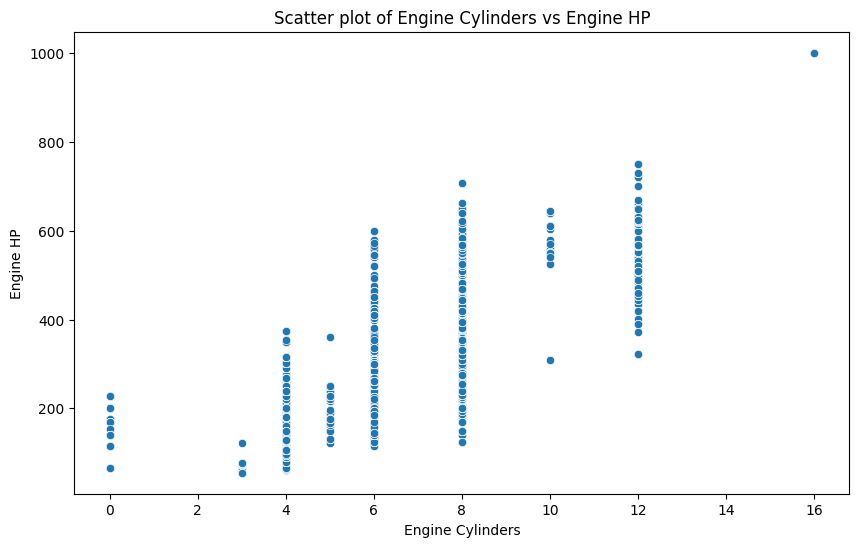

In [80]:
# Draw scatter plots between engine_hp and engine_cylinders
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.scatterplot(x='engine_cylinders', y='engine_hp', data=df_cleaned)
plt.title('Scatter plot of Engine Cylinders vs Engine HP')
plt.xlabel('Engine Cylinders')
plt.ylabel('Engine HP')
plt.show()

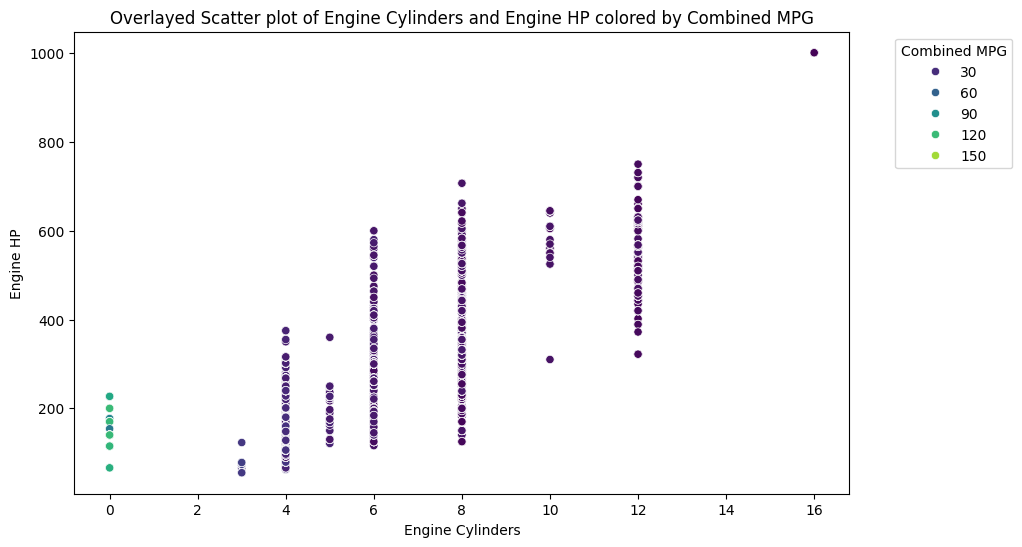

In [82]:
# Draw overlayed scatter plot between engine_hp, engine_cylinders and combined_mpg 

plt.figure(figsize=(10, 6))  
sns.scatterplot(x='engine_cylinders', y='engine_hp', hue='combined_mpg', data=df_cleaned, palette='viridis')
plt.title('Overlayed Scatter plot of Engine Cylinders and Engine HP colored by Combined MPG')
plt.xlabel('Engine Cylinders')
plt.ylabel('Engine HP')
plt.legend(title='Combined MPG', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Insights, Patterns and Trends:
- The average fuel economy across the dataset is approximately 22 mpg, but the distribution is left-skewed due to extreme high values (up to 137–354 mpg). These outliers could distort regression models if not addressed. As such, further analysis or transformation (e.g., log scaling or outlier removal) may be necessary during data preparation and modeling.
- Fuel type appears to be a strong predictor of fuel economy. Vehicles using electric fuel have the highest median mpg, followed by diesel, flex-fuel, regular gasoline, and other fuel types. This suggests that fuel type should be included as a key feature in predictive models. It is also noted that electric vehicle has no cylinders, so that some of the highest fuel economy stay on the left side at engine_cylinders = 0.
- Driven wheels categories (e.g., FWD, RWD, AWD) show similar median fuel economies, but a high number of outliers within each category suggests heteroscedasticity (unequal variance), which may impact model assumptions and performance.
- There is a negative correlation between engine horsepower and fuel economy. Vehicles with more than 600 HP generally achieve less than 20 mpg, indicating a tradeoff between power and efficiency.
- A similar negative relationship is observed between the number of cylinders and fuel economy, with more cylinders typically leading to lower mpg.
- Conversely, there is a positive correlation between engine horsepower and number of cylinders.

### Hypothesises and Business Values

1. Vehicles with electric fuel types have significantly higher fuel economy than combustion engines (gasoline/diesel).
- Justification: The box plot already shows the median fuel economy of electric vehicle significantly higher than other types. We can verify this statistically using ANOVA or other correlation statistics.
- Business value: Helps businesses forecast fuel efficiency based on fuel type and support marketing decisions about fuel efficiency advantages.
2. Higher engine horsepower is associated with lower fuel economy.
- Justification: A negative trend was observed between engine_hp and combined_mpg. Formal testing can validate if horsepower is a significant and consistent predictor of mpg.
- Business value: Informs trade-offs between power and efficiency and helps decision makings for specific market segments.
3. Vehicles with more engine cylinders tend to have lower fuel economy, even when controlling for horsepower.
- Justification: Cylinder count and horsepower are positively correlated, but isolating the effect of cylinders reveals more cylinders (additional friction and mass) also contribute to fuel inefficiency.
Business value: Supports autombile design to maintain performance while boosting efficiency.

